## Praktikum Maschinelles Lernen WS 15/16

 <table>
  <tr>
    <td>Name</td>
    <td>Vorname</td>
    <td>Matrikelnummer</td>
    <td>Datum</td>
  </tr>
  <tr>
    <td>Alt</td>
    <td>Tobias</td>
    <td>282385</td>
    <td>18.12.2015</td>
  </tr>
</table> 

<b>Aufgabe 3.1 - Perzeptron

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import linalg as LA
import scipy as sp
import urllib2
from urllib2 import urlopen, URLError, HTTPError
import zipfile
import tarfile
import sys
import os
from skimage import data, io, filter
from PIL import Image

<b>Teil A - Toy Dataset

In [2]:
# Funktion zum Erstellen des Datensatzes
#-----------------------------------------------------------------------------
# loc : float Mean (“centre”) of the distribution.
# scale : float Standard deviation (spread or “width”) of the distribution.
# size : int or tuple of ints, optional
# numpy.random.normal(loc=0.0, scale=1.0, size=None)

def createToyDataSet(ypos,numberOfData,clusterDistance,varianz):
    #sigma = sqrt(clusterBright) # mean and standard deviation
    #data1 = np.random.normal(mu, sigma, numberOfData)
    #data2 = np.random.normal(mu, sigma, numberOfData)

    mu = clusterDistance         #loc Paramter -> Abstand
    sigma = np.sqrt(varianz)        #scale Parameter -> Clusterbreite
    sizeOfData = numberOfData    #Anzahl Daten

    #np.vstack -> Stack arrays in sequence vertically
    X = np.vstack([np.random.normal(ypos+mu, sigma, (sizeOfData, 2)), np.random.normal(ypos-mu, sigma, (sizeOfData, 2))])
    return X 

In [8]:
#Graphische Darstellung
#-------------------------------------------------------------------------
def plotToyData(data,mu,varianz):
    fig = plt.figure()
    
    fig, ax = plt.subplot(figsize=(14,6))
    data1 = data[0]
    data2 = data[1]
    #plot data histogramm
    ax = plt.subplot(1,2,1)
    title('x/y Histogramm')
    count, bins, ignored = ax.hist(data, 30, normed=True)
    ax.plot(bins, 1/(sqrt(varianz) * np.sqrt(2 * np.pi)) * np.exp( - (bins)**2 / (2 * varianz) ),
         linewidth=2, color='g')
    # 1. Gaussverteilungen - Cluster 1
    x_plot = np.linspace(mu - 4*sqrt(varianz), mu + 4*sqrt(varianz), 100) # the x-values to use in the plot
    # compute the values of this density at the locations given by x_plot
    py = 1/np.sqrt(4*np.pi*varianz)*np.exp(-0.5*(x_plot-mu)**2/varianz)
    # sample some random values from this density
    x_samps = data
    # Plot the density
    ax.plot(x_plot, py)
    
    # 2. Gaussverteilungen - Cluster 2
    x_plot = np.linspace(-mu - 4*sqrt(varianz), -mu + 4*sqrt(varianz), 100) # the x-values to use in the plot
    # compute the values of this density at the locations given by x_plot
    py = 1/np.sqrt(4*np.pi*varianz)*np.exp(-0.5*(x_plot+mu)**2/varianz)
    # sample some random values from this density
    x_samps = data
    # Plot the density
    ax.plot(x_plot, py)

    # Scatter plot
    ax = plt.subplot(1,2,2)
    colors = np.hstack([np.zeros(len(data)/2), np.ones(len(data)/2)])
    plt.scatter(data[:, 0], data[:, 1], c=colors, edgecolors='none',cmap=plt.cm.Accent)

In [9]:
#Erzeugen der Daten (wie gewünscht einstellbar)
#---------------------------------------------------------------------------
varianz = 0.5      #Clusterbreite
numberOfData = 200 #Anzahl neuer Datenpunkte pro Cluster
mean= 1.5          #Abstand
ypos = 0           #y-Achsen-Verschiebung

toyData = createToyDataSet(ypos,numberOfData,mean,varianz)

In [5]:
plotToyData(toyData, mean, varianz)

NameError: global name 'subplots' is not defined

In [11]:
#Erzeugen des zugehörigen Labelvektor mit den Werten ±1
#-------------------------------------------------------------------
labelvector = np.ones(len(toyData)) 
labelvector[len(toyData)/2] *= -1
print 'ToyData Größe    :',shape(toyData),' 1.Klasse: ',toyData[0][0],'  2.Klasse: ', toyData[1][0]
print 'Labelvektor Größe:',shape(labelvector),' 1.Klasse: ',labelvector[0],'\t\t2.Klasse: ', labelvector[200]

ToyData Größe    : (400, 2)  1.Klasse:  1.81917296633   2.Klasse:  0.646027353619
Labelvektor Größe: (400,)  1.Klasse:  1.0 		2.Klasse:  -1.0


<b>Teil B - Perzeptron

In [13]:
import sys
import time

def restart_line(outputPrint):
    sys.stdout.write(outputPrint)
    sys.stdout.flush()
    sys.stdout.write('\r')

In [14]:
# Funktion für die Implementierung des Batch-Perzeptron mit Einzelbeispielkorrektur

correct = {}
XiList = []

def primal_Perzeptron(data,labelvector,lernrate,numberOfSteps,doPlot):
    
    Data = data
    # Alle Daten normalisieren
    Datanorm= norm(Data)
    Data = Data/Datanorm

    ### Initialisierung ###
    DataDimension = shape(data[0])
    # Normalvektor
    w= np.zeros(DataDimension)
    #Abbruchsbedingung
    i=0
    # Schwellwert
    b = 0 
    # Lernrate
    nk = lernrate
    # Anzahl Daten
    l = len(Data)
    # Liste groesster Norm in R
    norm_array=[] 
    abbruch = 0
    
    # Initialisierung für Plot -> Plot mit im Algorithmus
    if (doPlot):
        fig = plt.figure() #Abbildungsumgebung
        fig, ax = subplots(figsize=(14,15)) #Subplots
        
    pk = 0 # Subplotcounter - Zählen und Selektieren der Plots
    
    ### Algorithmus ### Jetzt wird es ernst...
    
    # Berechnung von R
    for ix in range (0,len(Data)):
        #numpy.linalg.norm - siehe import !
        norm_array.append(LA.norm(Data[ix]))
    R = np.max(norm_array)

    # führe x-Schritte aus
    alleKlassifiziert = True
    while True: 
        # loop counter
        i=(i + 1) %l
        xi = Data[i]
            
        # -->falsch klassifiziert
        mi= labelvector[i]*(np.dot(w,xi)+b)
        correct.update({'i':i,'w': shape(w),'xi':xi,'mi':mi})
        XiList.append(xi)
        if mi<=0:
            alleKlassifiziert = False
            w = w+nk*labelvector[i]*xi # neuer Gewichtsvektor w <- w + nk*yi*xi
            b = b+(nk*labelvector[i]*(R**2))
                
            # Zählen und Zeichnen der Korrekturschritte
            pk+=1 # Subplotcounter ++
            if pk < 10 and doPlot: # reserviere für letzten Plot
                zeichneTrennebene(data,pk,2,5,w,b,alleKlassifiziert)
                           
        # Alle Daten wurden durchlaufen. Wurden alle klassifiziert?
        if(i==0 and alleKlassifiziert):
            print 'alle Klassifiziert'
            if doPlot:
                zeichneTrennebene(data,pk,2,5,w,b,alleKlassifiziert)
            break
        
        # Wieder am Listenanfang
        if(i==0): 
            abbruch +=1
            alleKlassifiziert = True #reset
            outputPrint = 'Abbruch in '+str(numberOfSteps-abbruch)
            restart_line(outputPrint)


            #Abbruch nach numberOfsteps Schritten
            if (abbruch>numberOfSteps):
                print 'Nicht Klassifizierbar nach ',abbruch,'Schritten'
                if doPlot:
                    zeichneTrennebene(data,pk,2,5,w,b,alleKlassifiziert) 
                break

   
    return w,b

In [15]:
# Funktion zur Berechnung der Trennlinie aus dem Normalvektor und Schwellwert

def zeichneTrennebene(toyData,pk,row,column,w,b,alleKlassifiziert):
        # Convert the input to an array
        plot_limits = np.asarray([-5, 4]) #xy axis values in plot
        
        # Zeichnen des i. Korrekturschritt ausser es ist nur noch ein Platz im Plott frei
        if pk<(row*column):
            # Erstelle neuen Subplot und Titel
            ax = plt.subplot(row,column,pk); 
            ax.axis([plot_limits[0],plot_limits[1], plot_limits[0], plot_limits[1]])
            title('Korrekturschritt:'+str(pk));
            # Zeichne Daten Punkte Wolke
            plot(toyData[:len(toyData)/2, 0], toyData[:len(toyData)/2, 1], 'bo');# bo = blau, x = xes
            plot(toyData[len(toyData)/2:, 0], toyData[len(toyData)/2:, 1], 'go');# g=green, y = yellow
            
            # Zeichne Trennebene 0 = w*x+b
            x0,x1 =get_plane_coordinates(w, b, plot_limits)
            plot(x0,x1,'r--')# Berechne Trennebene mit get_plane_coordinates()
             
        #Bei zu vielen Plots, plotte nur noch den letzten Plot
        elif(alleKlassifiziert): # letzten Schritt plotten  last == 0
            # Erstelle letzten subplot und Titel
            ax = plt.subplot(2,5,row*column); 
            title('letzter Korrekturschritt:'+str(pk));
            # Zeichne Daten Punkte Wolke
            plot(toyData[:len(toyData)/2, 0], toyData[:len(toyData)/2, 1], 'bo');# bo = blaupuntkt, x = xes
            plot(toyData[len(toyData)/2:, 0], toyData[len(toyData)/2:, 1], 'go');# g=green, y = yellow
            
            # Zeichne Trennebene 0 = w*x+b
            x0,x1 =get_plane_coordinates(w, b, plot_limits)
            #print 'x0:',x0,'x1:',x1
            plot(x0,x1,'r--')# berechne Trennebene mit get_plane_coordinates()

In [16]:
# Gibt allgemeine Informationen über die Detektion

def detectionInformation(w ,b ,data, labels):  
    hit = 0         # richig-positiv 
    cor_neg = 0     # richtig-negativ
    false_pos = 0   # Fehlalarm flasch-positiv
    miss = 0        # falsch-negativ
    
    for i in range (0, len(data)):
        mi =(np.dot(w,data[i])+b)>0
        #mi = np.sign(np.dot(w,data[i])+b)>0
        if  mi:
            if labels[i] == 1:
                hit += 1
            else:
                false_pos += 1
        else:
            if labels[i] == 1:
                miss += 1
            else:
                cor_neg += 1
       
    print "Hit(richtig-positiv): \t\t\t\t", str(round(100.0 * hit / (hit + miss),2)),'%',"(",hit,")"
    print "Korrekte Rückweisung(Richtig-Negativ): \t\t" , str (round(100.0 * cor_neg / (cor_neg + false_pos),2)),'%',"(",cor_neg,")"
    print "Fehlalarmrate(falsch-positiv): \t\t\t", str (round(100.0 * false_pos / (cor_neg + false_pos),2)),'%',"(",false_pos,")"
    print "Miss(falsch-negativ): \t\t\t\t", str(round(100.0 * miss / (hit + miss),2)),'%','(',miss,')'

In [17]:
# Berechnet Trennebene
# Quelle: http://nbviewer.ipython.org/github/SheffieldML/notebook/blob/master/lab_classes/machines_and_intelligence/MI_Lab_class.ipynb
def get_plane_coordinates(w, b, plot_limits):
    
    if abs(w[1])>abs(w[0]):
        # if w[1]>w[0] in absolute value, plane is likely to be leaving tops of plot
        x0 = plot_limits
        x1 = -(b + x0*w[0])/w[1]
    else:
        # otherwise plane is likely to be leaving sides of plot.
        x1 = plot_limits
        x0 = -(b + x1*w[1])/w[0]
    return x0, x1

Nicht Klassifizierbar nach  2001 Schritten
Hit(richtig-positiv): 				50.38 % ( 201 )
Korrekte Rückweisung(Richtig-Negativ): 		0.0 % ( 0 )
Fehlalarmrate(falsch-positiv): 			100.0 % ( 1 )
Miss(falsch-negativ): 				49.62 % ( 198 )
w [-0.00302235 -0.00355585] b 0.000896042235216


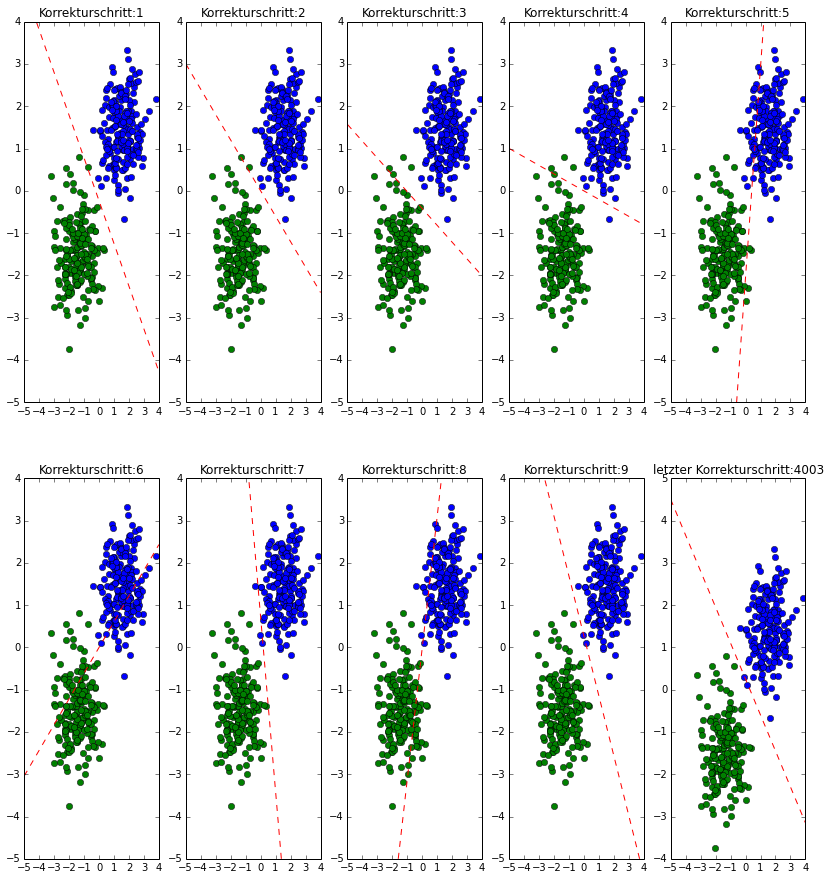

In [18]:
#Gegentest mit der Funktion
w,b = primal_Perzeptron(toyData,labelvector,0.1,2000,True)
detectionInformation(w ,b,toyData, labelvector)
print 'w',w,'b',b

<matplotlib.contour.QuadContourSet instance at 0x7f77fc3f4290>

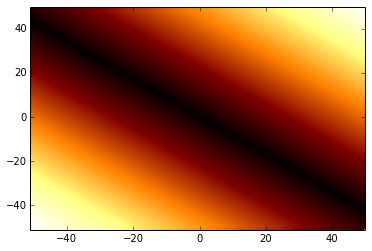

In [19]:
# Stellen Sie zusätzlich die Diskriminantenfunktion des Perzeptrons, 
# d.h. den funktionalen Abstand als Heatmap (Funktion contourf()) über
# ein Gitter der Größe 50 x 50 dar, das den Bereich der Trainingsdaten abdeckt.
# contourf
window_size = np.asarray([-50, 50])

x = np.arange(window_size[0]-1, window_size[1]+1)
y = np.arange(window_size[0]-1, window_size[1]+1)

X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
tmp_array = np.zeros(2)

for i in range(0, len(Z)):
    for j in range (0, len(Z)):
        tmp_array[0] = X[i][j]
        tmp_array[1] = Y[i][j]
        scalar = np.dot(w,tmp_array)
        res = scalar + b
        if res < 0:
            res = -res
        Z[i][j] = res
contour(X, Y, Z, 100,linewidths = (10,), zorder=-1, cmap=plt.get_cmap('afmhot'))

<b>Teil C - Test an realen Daten

In [15]:
downloadFileName = 'lfw-funneled.tgz'

In [16]:
#Pfad des entpackten Ordners ermitteln
path = os.path.curdir+'/'+downloadFileName.replace('.tgz', '/')
path =path.replace('-','_')
#Alle Ordnernamen eintragen
fileList = os.listdir(path)
NameList=[]
NameFileList=[]
filecount=0 #Anzahl wichtiger Dateien zählen (für PCA)
# Anzahl bilder >70
for i in range(0,len(fileList)-1):
    if (fileList[i].find('.') == -1) and (len( os.listdir( path+fileList[i]+'/' ) ) >= 70):
        NameList.append(fileList[i].replace('_',' ')) #Namen hinzufügen und schön schreiben
        NameFileList.append(fileList[i])
        filecount += len( os.listdir( path+fileList[i]+'/'))
        print 'add' ,fileList[i].replace('_',' '), 'to Namelist', 'number of pictures: ', len( os.listdir( path+fileList[i]+'/'))
    
print 'Gesamte Anzahl der Dateien >70:', filecount        
NameList

add Ariel Sharon to Namelist number of pictures:  77
add Tony Blair to Namelist number of pictures:  144
add Donald Rumsfeld to Namelist number of pictures:  121
add George W Bush to Namelist number of pictures:  530
add Colin Powell to Namelist number of pictures:  236
add Hugo Chavez to Namelist number of pictures:  71
add Gerhard Schroeder to Namelist number of pictures:  109
Gesamte Anzahl der Dateien >70: 1288


['Ariel Sharon',
 'Tony Blair',
 'Donald Rumsfeld',
 'George W Bush',
 'Colin Powell',
 'Hugo Chavez',
 'Gerhard Schroeder']

<b>Vorbereitung Hilfsfunktionen

In [18]:
# Würfelt Index
def indexShuffel(numberOf):
    result=np.arange(0, numberOf, dtype=np.int)
    random.shuffle(result)
    return result

In [46]:
#Python Scirpt zum laden der Bilder mit 1/8 der Grösse
def imageLoad_np(path):
    image = io.imread(path, as_grey=True)
    tmpsize = image.shape #für print
    image = sp.misc.imresize(image,12.5/100)     
    ImageSize=shape(image)
    Image_array = np.reshape(image, (1, shape(image)[0]*shape(image)[1]))
    print path,'Alte Bildgröße: ',tmpsize,'neue Bildgröße',image.shape, 'geladen'
    return Image_array

In [47]:
# Aus 2. Übung Bildgrößen testen
picture = io.imread(path+NameFileList[0]+'/'+'Ariel_Sharon_0001.jpg', as_grey=True) #Grauwert

ImageSize = sp.misc.imresize(picture, 12.5/100 ) #Prozent vom Ursprungsbild: 1/8 = 12,5%
ImageSize = ImageSize.shape

In [48]:
#Liste aller Filenamen der Bilder
image_List=[]
for i in range(0,len(NameFileList)):
    image_List.append(os.listdir( path+NameFileList[i]+'/'))

In [49]:
# Funktion für Test- und Trainingsmatrix
def get_design_and_Test_Matrix(percent):

    # Erstelle und lade die Bilder in die ImageMatrix(Designmatrix)
    designmatrix_np= []
    
    # Speichert die ersten Bilder der Personen 
    for j in range (0,len(NameFileList)):
        newline_np=[]
        # indexShuffel function call
        randomizedList = indexShuffel (len(image_List[j]))
        for i in range(0,int(round(len(image_List[j])*percent))):
            newline_np.append(imageLoad_np(path+NameFileList[j]+'/'+image_List[j][randomizedList[i]])[0])
        designmatrix_np.append(newline_np)
    print '- ',percent*100,'% der Bilder wurden in die Designmatrix geladen - '

    # Erstelle und lade die TestBilder in die ImageMatrix(Designmatrix)
    testbilder_np= []
    
    # Speichert restliche Bild der Personen 
    for j in range (0,len(NameFileList)):
        newline_np=[]
        randomizedList = indexShuffel (len(image_List[j]))
        for i in range(int(round(len(image_List[j])*percent))+1,len(image_List[j])):
            newline_np.append(imageLoad_np(path+NameFileList[j]+'/'+image_List[j][randomizedList[i]])[0])
        testbilder_np.append(newline_np)
    print '- ',percent*100,'% der Bilder wurden in die Testbilder geladen - '
    
    return designmatrix_np,testbilder_np

In [50]:
# Arrays in richtige Form bringen
def getInForm(Data):
    NewData = Data
    if shape(Data) == (size(Data),):
        NewData = np.zeros((filecount,ImageSize[0]*ImageSize[1]))
        for i in range (0,len(Data)):
            for k in range (0,len(Data[i])):
                NewData[k,:] = Data[i][k]
        print '- getInForm: Achtung übergebene Daten wurden angepasst und überschrieben! -'
        print 'von shape: ',shape(Data), 'nach: ', shape(NewData)
    else:
        print '- getInForm: Daten sind schon korrekt -'
    return NewData;

# Hauptkomponentenanalyse
def PCA(array_np):
    Data = copy(array_np)
    for i in range(0, len(array_np)-1):
        mean = np.mean(array_np[i])
        for j in range(0,len(array_np[i])-1):
            array_np[i][j] -= mean
    
    Data = getInForm(Data)
    return np.linalg.svd(Data, full_matrices=True)

In [51]:
# PCA(Hauptkomponentenanalyse)
TrainingsBilder,TestBilder = get_design_and_Test_Matrix(0.6)
U, d, VT  = PCA(TrainingsBilder)
V=VT.T    #V = VT transponiert
print 'u:', U.shape
print 'd:', d.shape
print 'VT:', VT.shape
print 'V:', V.shape


./lfw_funneled/Ariel_Sharon/Ariel_Sharon_0033.jpg Alte Bildgröße:  (250, 250) neue Bildgröße (31, 31) geladen
./lfw_funneled/Ariel_Sharon/Ariel_Sharon_0064.jpg Alte Bildgröße:  (250, 250) neue Bildgröße (31, 31) geladen
./lfw_funneled/Ariel_Sharon/Ariel_Sharon_0045.jpg Alte Bildgröße:  (250, 250) neue Bildgröße (31, 31) geladen
./lfw_funneled/Ariel_Sharon/Ariel_Sharon_0041.jpg Alte Bildgröße:  (250, 250) neue Bildgröße (31, 31) geladen
./lfw_funneled/Ariel_Sharon/Ariel_Sharon_0066.jpg Alte Bildgröße:  (250, 250) neue Bildgröße (31, 31) geladen
./lfw_funneled/Ariel_Sharon/Ariel_Sharon_0027.jpg Alte Bildgröße:  (250, 250) neue Bildgröße (31, 31) geladen
./lfw_funneled/Ariel_Sharon/Ariel_Sharon_0067.jpg Alte Bildgröße:  (250, 250) neue Bildgröße (31, 31) geladen
./lfw_funneled/Ariel_Sharon/Ariel_Sharon_0009.jpg Alte Bildgröße:  (250, 250) neue Bildgröße (31, 31) geladen
./lfw_funneled/Ariel_Sharon/Ariel_Sharon_0048.jpg Alte Bildgröße:  (250, 250) neue Bildgröße (31, 31) geladen
./lfw_funn

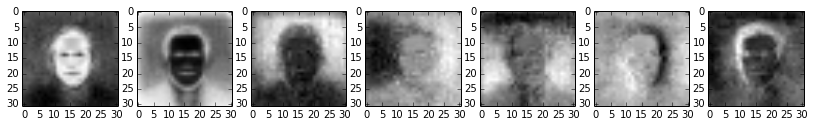

In [52]:
# Darstellen der 7 ersten Eigengesichter als Bild
eigengesichter = []
faces = []
for i in range(0, 7):
    face = np.reshape(V[:,i], ImageSize)
    eigengesichter.append(face)
    faces.append(eigengesichter[i])

    min = faces[i].min()
    max = faces[i].max()

    faces[i] = faces[i] - min
    faces[i] = faces[i] / (max-min)
    
fig = plt.figure()    
fig, ax = subplots(figsize=(14, 14))
for j in range (0,7):
    ax = plt.subplot(1,7,j+1) 
    ax.imshow(faces[j])

gray()
plt.show()

In [55]:
# Projizieren Sie jedes der Trainings- und Testbilder auf die ersten 7 Eigengesichter (Skalarprodukts)

imagecountTest =0
imagecountTraining =0
# standardisieren
for i in range(0, len(TestBilder)):
    mean = np.mean(TestBilder[i])
    TestBilder[i] -= mean
    imagecountTest += len(TestBilder[i]) 

# Standardisieren
for i in range(0, len(TrainingsBilder)):
    mean = np.mean(TrainingsBilder[i])
    TrainingsBilder[i] -= mean
    imagecountTraining += len(TrainingsBilder[i])  
    
# Testbilder  
projezierteTestBilder = np.zeros((7,imagecountTest))
for i in range(0, len(TestBilder)):
    for pic in range(0,len(TestBilder[i])):
        for j in range(0,7):
            projezierteTestBilder[j][i+pic] = np.dot(VT[:,j], TestBilder[i][pic])
           
# Trainingsbilder             
projezierteTrainingsBilder = np.zeros((7,imagecountTraining))
for i in range(0, len(TrainingsBilder)):
    for pic in range(0,len(TrainingsBilder[i])):
        # erste 7 Eigengesichter
        for j in range(0,7):
            projezierteTrainingsBilder[j][i+pic] = np.dot(VT[:,j], TrainingsBilder[i][pic])

        
# Sie erhalten so für jedes Trainings- und Testbild 7 Merkmale.
print 'Merkmale Shape: ',shape(projezierteTestBilder),shape(projezierteTrainingsBilder)

Merkmale Shape:  (7, 508) (7, 773)


<b>Trainingskonstante

In [73]:
SuchePerson =  'George W Bush'
#SuchePerson = 'Ariel Sharon'
#SuchePerson = 'Colin Powell'
#SuchePerson = 'Donald Rumsfeld'
#SuchePerson =  'Gerhard Schroeder'
#SuchePerson =  'Hugo Chavez'
#SuchePerson =  'Tony Blair'

In [74]:
# George-W.-Bush-Detektor
# Erstellt Labelliste und Bilderliste aller Bilder
def GeorgeW_Bush_Detektor(Data,Name):
   # imagesList= []
    labelList =[]
    for person in range(0,len(NameList)):
        for picture in range(0,len(Data[person])):
            if(person==NameList.index(Name)):
                #imagesList.append(Data[person]) Wert +1
                labelList.append(1)
            else:
                #imagesList.append(Data[person]) Wert -1
                labelList.append(-1)
    return labelList

In [75]:
# Unter Verwendung der Hauptkomponenten (PCA)
breakIterate = 2000
lernrate = 0.1

labelList=GeorgeW_Bush_Detektor(TrainingsBilder,SuchePerson) # Erstelle Perzeptron Test Daten
HKgewichtsVektor_w,HKSchwellwert_b = primal_Perzeptron(projezierteTrainingsBilder[NameList.index(SuchePerson)],labelList,lernrate,breakIterate,False )

Nicht Klassifizierbar nach  2001 Schritten


<b>Detektionswahrscheinlichkeit</b>

<b>Richtig-Negativ-Rate, Fehlalarmrate, Falsch-Negativ-Rate</b>

In [79]:
# Trainingsbilder
print SuchePerson
detectionInformation(HKgewichtsVektor_w ,HKSchwellwert_b,projezierteTrainingsBilder[NameList.index(SuchePerson)], labelList)
print HKgewichtsVektor_w,HKSchwellwert_b

George W Bush
Hit(richtig-positiv): 				3.46 % ( 11 )
Korrekte Rückweisung(Richtig-Negativ): 		86.15 % ( 392 )
Fehlalarmrate(falsch-positiv): 			13.85 % ( 63 )
Miss(falsch-negativ): 				96.54 % ( 307 )
-0.00117371496226 -0.00191590813532


In [80]:
# Testbilder
print SuchePerson
detectionInformation(HKgewichtsVektor_w ,HKSchwellwert_b,projezierteTestBilder[NameList.index(SuchePerson)], GeorgeW_Bush_Detektor(TestBilder,SuchePerson))
print HKgewichtsVektor_w,HKSchwellwert_b

George W Bush
Hit(richtig-positiv): 				31.75 % ( 67 )
Korrekte Rückweisung(Richtig-Negativ): 		62.63 % ( 186 )
Fehlalarmrate(falsch-positiv): 			37.37 % ( 111 )
Miss(falsch-negativ): 				68.25 % ( 144 )
-0.00117371496226 -0.00191590813532
